# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.223315479000007
GPU (s):
0.036864002000015716
GPU speedup over CPU: 87x


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, glob, json
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: grpcio, termcolor, keras-preprocessing, astunparse, gast, wrapt, protobuf, wheel, flatbuffers, typing-extensions, absl-py, google-pasta, tensorboard, numpy, keras-nightly, opt-einsum, tensorflow-estimator, h5py, six
Required-by: kapre


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.INFO)
logger.setLevel(logging.ERROR)

In [ ]:
train_dir = '/content/drive/MyDrive/Binit/pneuminia_cnn/chest_xray/train'
test_dir = '/content/drive/MyDrive/Binit/pneuminia_cnn/chest_xray/test'
val_dir = '/content/drive/MyDrive/Binit/pneuminia_cnn/chest_xray/val'
print(f'Data directory contains: {os.listdir(val_dir)}')

Data directory contains: ['NORMAL', 'PNEUMONIA']


In [ ]:
print(f'Num of Normal samples in train data = {len(os.listdir(os.path.join(train_dir, "NORMAL")))}')
print(f'Num of PNEUMONIA samples in train data = {len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))}')
print(f'Num of Normal samples in test data = {len(os.listdir(os.path.join(test_dir, "NORMAL")))}')
print(f'Num of PNEUMONIA samples in test data = {len(os.listdir(os.path.join(test_dir, "PNEUMONIA")))}')
print(f'Num of Normal samples in val data = {len(os.listdir(os.path.join(val_dir, "NORMAL")))}')
print(f'Num of PNEUMONIA samples in val data = {len(os.listdir(os.path.join(val_dir, "PNEUMONIA")))}')

Num of Normal samples in train data = 1359
Num of PNEUMONIA samples in train data = 3880
Num of Normal samples in test data = 234
Num of PNEUMONIA samples in test data = 390
Num of Normal samples in val data = 8
Num of PNEUMONIA samples in val data = 8


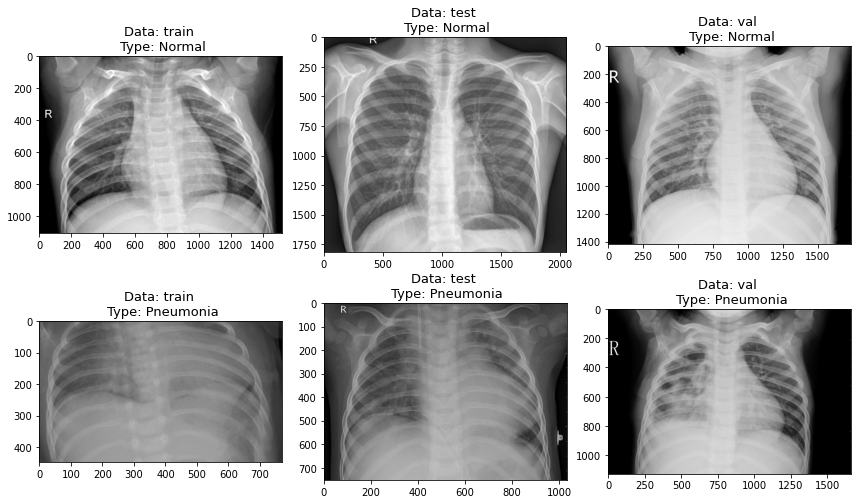

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (12, 7))
ax = ax.ravel()
plt.tight_layout()

for i, set_path in enumerate([train_dir, test_dir, val_dir]):
    ax[i].imshow(plt.imread(set_path + '/NORMAL/' + os.listdir(set_path + '/NORMAL')[1]), cmap = 'gray')
    ax[i].set_title('Data: {} \n Type: Normal'.format(set_path.split('/')[-1]), fontsize = 13)
    ax[i+3].imshow(plt.imread(set_path + '/PNEUMONIA/' + os.listdir(set_path + '/PNEUMONIA')[1]), cmap = 'gray')
    ax[i+3].set_title('Data: {} \n Type: Pneumonia'.format(set_path.split('/')[-1]), fontsize = 13)

Normal image original size = (1152, 1422, 3)
Pneumonia image original size = (1056, 1248, 3)


Text(0.5, 1.0, 'PNEUMNIA_CLAHE')

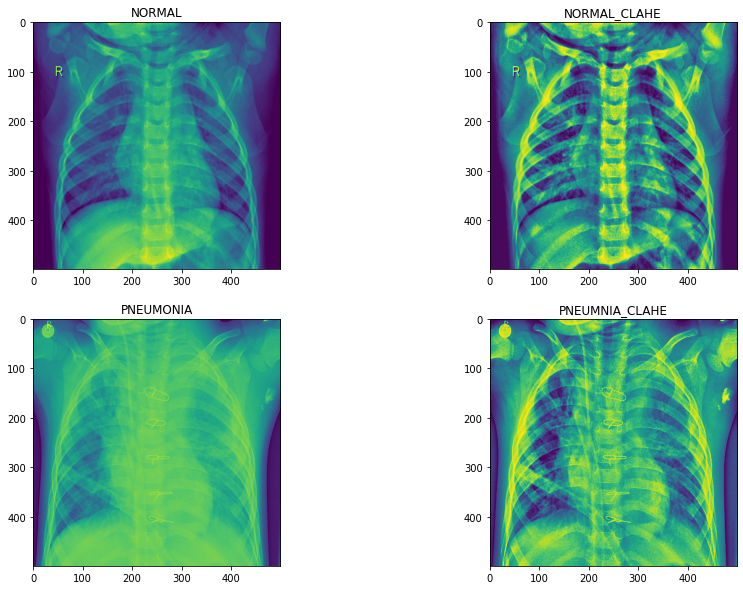

In [ ]:
clahe = cv2.createCLAHE(clipLimit=5)

img_normal = cv2.imread(os.path.join(train_dir, 'NORMAL', 'IM-0117-0001.jpeg'))
print(f'Normal image original size = {img_normal.shape}')
img_normal = cv2.resize(img_normal, (500, 500))
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2GRAY)
img_normal_clahe = clahe.apply(img_normal)

img_pneumonia = cv2.imread(os.path.join(train_dir, 'PNEUMONIA', 'person3_bacteria_10.jpeg'))
print(f'Pneumonia image original size = {img_pneumonia.shape}')
img_pneumonia = cv2.resize(img_pneumonia, (500, 500))
img_pneumonia = cv2.cvtColor(img_pneumonia, cv2.COLOR_BGR2GRAY)
img_pneumonia_clahe = clahe.apply(img_pneumonia)

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0,0].imshow(img_normal)
axs[0,0].set_title("NORMAL")
axs[0,1].imshow(img_normal_clahe)
axs[0,1].set_title("NORMAL_CLAHE")
axs[1,0].imshow(img_pneumonia)
axs[1,0].set_title("PNEUMONIA")
axs[1,1].imshow(img_pneumonia_clahe)
axs[1,1].set_title("PNEUMNIA_CLAHE")

# **Data Augmentation using data generator**
We need generator because training big amount of images can take us to memory insufficient error. Here generator will do all our image processing task for training. We will apply image augumentation only on the training images not on testing or validation.

In [ ]:
img_width, img_height = (224, 224)
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.2, width_shift_range=0.1, 
                                   height_shift_range=0.1, brightness_range=[0.4, 1.0], horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_width, img_height), batch_size=batch_size,
                                                    class_mode='binary', shuffle=True)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(img_width, img_height), batch_size=batch_size,
                                                    class_mode='binary')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(img_width, img_height), batch_size=batch_size,
                                                    class_mode='binary')

Found 5239 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
n_train = train_generator.n
n_val = val_generator.n
n_test = test_generator.n
print(f'Train={n_train} samples | Test={n_test} samples | Val={n_val} samples')

epochs = 20
batch_size = 16

Train=5239 samples | Test=624 samples | Val=16 samples


## **Densenet169**

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

In [ ]:
base = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
tf.keras.backend.clear_session()

for layer in base.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1664)              6656      
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

In [ ]:
opt = Adam(lr=0.0001)

model.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss',
                   mode='min', 
                   min_delta=0.01,
                   patience=8,
                   restore_best_weights=True,
                   verbose=1, 
                   baseline=None)

rlrp = ReduceLROnPlateau(monitor='val_loss', 
                         mode='min',
                         min_delta=0.01, 
                         factor=0.01, 
                         patience=5, verbose=1)

model_save = ModelCheckpoint('/content/drive/MyDrive/Binit/pneuminia_cnn/models/densenet_169.h5', 
                             save_best_only=True, 
                             save_weights_only=False, 
                             monitor='val_loss', 
                             mode='min', verbose=1)

NameError: ignored

# Model Training

In [ ]:
densenet_history = model.fit(train_generator,
                             steps_per_epoch=n_train // batch_size,
                             epochs=20,
                             validation_data=test_generator,
                             callbacks=[model_save, rlrp],
                             verbose=1)

Epoch 1/20
327/327 [==============================] - 1555s 5s/step - loss: 0.5689 - accuracy: 0.7201 - val_loss: 0.3768 - val_accuracy: 0.8381

Epoch 00001: val_loss improved from inf to 0.37683, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/densenet_169.h5
Epoch 2/20
327/327 [==============================] - 148s 451ms/step - loss: 0.3067 - accuracy: 0.8719 - val_loss: 0.3084 - val_accuracy: 0.8766

Epoch 00002: val_loss improved from 0.37683 to 0.30842, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/densenet_169.h5
Epoch 3/20
327/327 [==============================] - 148s 454ms/step - loss: 0.2559 - accuracy: 0.8962 - val_loss: 0.2760 - val_accuracy: 0.8878

Epoch 00003: val_loss improved from 0.30842 to 0.27596, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/densenet_169.h5
Epoch 4/20
327/327 [==============================] - 149s 455ms/step - loss: 0.2251 - accuracy: 0.9091 - val_loss: 0.2630 - val_accuracy: 0.9006

Epoc

# Save History

In [ ]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/Binit/pneuminia_cnn/models/densenet_169_history', 'wb') as hf:
  pickle.dump(densenet_history.history, hf)

## Load Model and History

In [ ]:
densenet_model_from_disk = load_model('/content/drive/MyDrive/Binit/pneuminia_cnn/models/densenet_169.h5')
with open('/content/drive/MyDrive/Binit/pneuminia_cnn/models/densenet_169_history', 'rb') as h:
  densenet_history_from_disk = pickle.load(h)

In [ ]:
def plot_training(history):

  train_accuracy = history['accuracy']
  val_accuracy = history['val_accuracy']
  train_loss = history['loss']
  val_loss = history['val_loss']
  epoch_range = range(len(train_accuracy))

  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epoch_range, train_accuracy, label='Training Accuracy')
  plt.plot(epoch_range, val_accuracy, label='Validation Accuracy')
  plt.title('Accuracy')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(epoch_range, train_loss, label='Training Loss')
  plt.plot(epoch_range, val_loss, label='Validation Loss')
  plt.title('Loss')
  plt.legend(loc='upper right')
  plt.show()

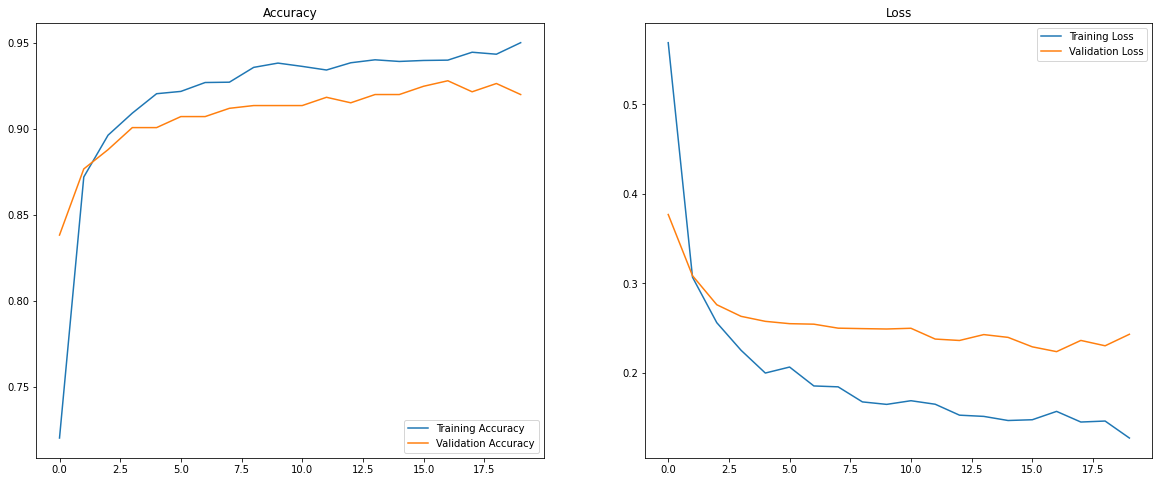

In [ ]:
plot_training(densenet_history_from_disk)

In [ ]:
from PIL import Image
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def process_image(image):
  image = image / 255
  image = cv2.resize(image, (224, 224))
  return image

def predict_image(model, image_path):
  img = cv2.imread(image_path)
  img = np.asarray(img)
  processed_img = process_image(img)
  processed_img = np.expand_dims(processed_img, axis=0)
  pred = model.predict(processed_img)
  return pred

def testing(model, test_df):
    """ the passed data must be the img_path columns and label column"""
    base_pred =[]
    for image in test_df.img_path:
        base_pred.append(predict_image(model, image)[0][0])
    
    final_base_pred  = np.where(np.array(base_pred)>0.5,1,0)
    actual_label = test_df['label']
    # print(final_base_pred)

    print(classification_report(actual_label, final_base_pred))
    matrix=confusion_matrix(actual_label, final_base_pred)
    sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

def prep_test_data(test_dir):
  test_data = []
  test_pneumonia_path = os.path.join(test_dir, 'PNEUMONIA')
  test_normal_path = os.path.join(test_dir, 'NORMAL')

  for filename in os.listdir(test_normal_path):
    test_data.append((os.path.join(test_normal_path, filename), 0))
  for filename in os.listdir(test_pneumonia_path):
    test_data.append((os.path.join(test_pneumonia_path, filename), 1))
  test_df = pd.DataFrame(test_data, columns=['img_path', 'label'])
  return test_df

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       234
           1       0.93      0.95      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.92      0.92       624
weighted avg       0.92      0.92      0.92       624



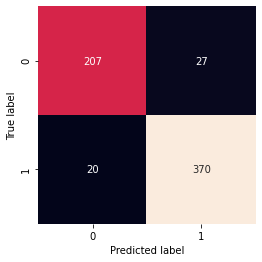

In [ ]:
test_df = prep_test_data(test_dir)
testing(densenet_model_from_disk, test_df)

# Mobilenet

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
def build_model(model, n_dense1, n_dense2, n_class):
  base = model(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  tf.keras.backend.clear_session()

  for layer in base.layers:
      layer.trainable = False
      
  model = Sequential()
  model.add(base)
  model.add(GlobalAveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dense(n_dense1, activation='relu'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(n_dense2, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_class, activation='sigmoid'))
  print(model.summary())
  return model

In [ ]:
mobilenet_model = build_model(model=MobileNetV2, n_dense1=256, n_dense2=128, n_class=1)

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
___________________________________________________________

In [ ]:
opt = Adam(lr=0.0001)
mobilenet_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

EStop = EarlyStopping(monitor='val_accuracy', min_delta=0.001,
                              patience=7, verbose=1, mode='max',
                              baseline=None, restore_best_weights=True)
rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.01, patience=4, 
                         verbose=4, mode='max', min_delta=0.01)
model_save = ModelCheckpoint('/content/drive/MyDrive/Binit/pneuminia_cnn/models/mobilenet.h5',
                             monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='min')

In [ ]:
mobilenet_history = mobilenet_model.fit(train_generator, epochs=20, 
                                        validation_data=test_generator,
                                        steps_per_epoch=n_train//batch_size, 
                                        callbacks=[EStop, model_save, rlrp])

Epoch 1/20
327/327 [==============================] - 1557s 5s/step - loss: 0.4347 - accuracy: 0.7930 - val_loss: 0.3130 - val_accuracy: 0.8830

Epoch 00001: val_loss improved from inf to 0.31299, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/mobilenet.h5
Epoch 2/20
327/327 [==============================] - 116s 355ms/step - loss: 0.2705 - accuracy: 0.8886 - val_loss: 0.2552 - val_accuracy: 0.8958

Epoch 00002: val_loss improved from 0.31299 to 0.25516, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/mobilenet.h5
Epoch 3/20
327/327 [==============================] - 116s 356ms/step - loss: 0.2340 - accuracy: 0.8987 - val_loss: 0.2313 - val_accuracy: 0.8990

Epoch 00003: val_loss improved from 0.25516 to 0.23130, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/mobilenet.h5
Epoch 4/20
327/327 [==============================] - 116s 355ms/step - loss: 0.2148 - accuracy: 0.9159 - val_loss: 0.2252 - val_accuracy: 0.9103

Epoch 00004: 

## Save History

In [ ]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/Binit/pneuminia_cnn/models/mobilenet_history', 'wb') as hf:
  pickle.dump(mobilenet_history.history, hf)

## Load Model and History

In [ ]:
mobilenet_model_from_disk = load_model('/content/drive/MyDrive/Binit/pneuminia_cnn/models/mobilenet.h5')
with open('/content/drive/MyDrive/Binit/pneuminia_cnn/models/mobilenet_history', 'rb') as h:
  mobilenet_history_from_disk = pickle.load(h)

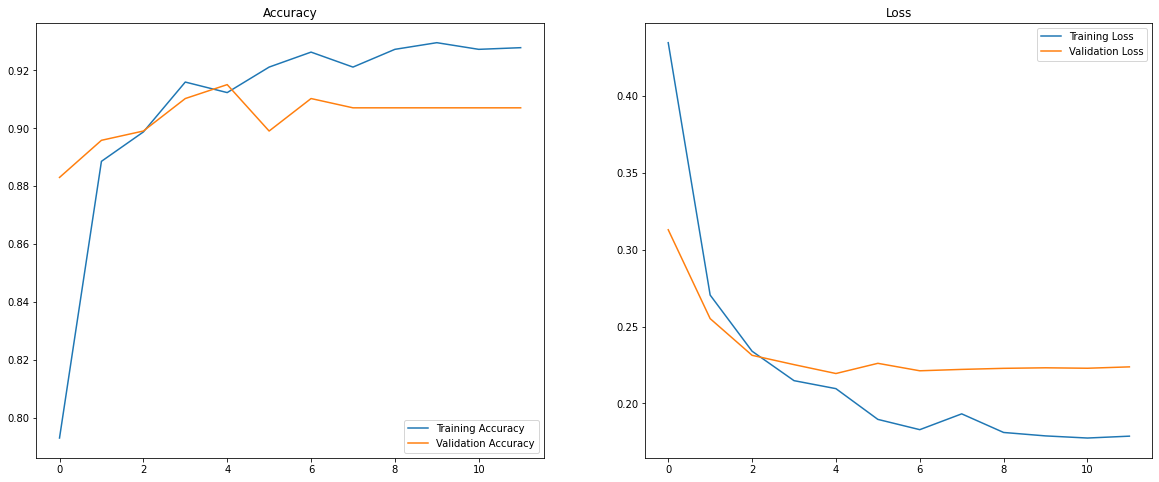

In [ ]:
plot_training(mobilenet_history_from_disk)

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       234
           1       0.95      0.90      0.92       390

    accuracy                           0.91       624
   macro avg       0.90      0.91      0.90       624
weighted avg       0.91      0.91      0.91       624



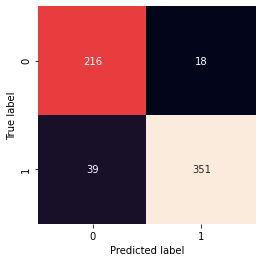

In [ ]:
test_df = prep_test_data(test_dir)
testing(mobilenet_model_from_disk, test_df)

# **Stacked Model: Mobilenet & Densenet**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate
import pickle

In [ ]:
input_shape = (224, 224, 3)
input_layer = Input(shape=input_shape)

base_densenet = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_densenet.layers:
  layer.trainable = False
for layer in base_mobilenet.layers:
  layer.trainable = False

model_densenet = base_densenet(input_layer)
model_densenet = GlobalAveragePooling2D()(model_densenet)
output_densenet = Flatten()(model_densenet)

model_mobilenet = base_mobilenet(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)

model_merged = Concatenate()([output_densenet, output_mobilenet])
x = BatchNormalization()(model_merged)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
stacked_model = tf.keras.Model(inputs=input_layer, outputs=x)

stacked_model.summary()

51879936/51877672 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet169 (Functional)        (None, 7, 7, 1664)   12642880    input_1[0][0]                    
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 7, 7, 1280)   2257984     input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1664)         0           densenet169[0][0]                
_____________________________

In [ ]:
opt = Adam(learning_rate=0.0001)
stacked_model.compile(loss='binary_crossentropy',
                      optimizer=opt, metrics=['accuracy'])
EarlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=7, verbose=1,
                          mode='auto', baseline=None, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.01, min_delta=0.01, patience=6, 
                        mode='max', verbose=1 )
model_save = ModelCheckpoint('/content/drive/MyDrive/Binit/pneuminia_cnn/models/stacked_mobilenet_densenet.h5',
                             monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False)

In [ ]:
stacked_history = stacked_model.fit(train_generator,
                                    steps_per_epoch=n_train//batch_size,
                                    validation_data=test_generator,
                                    epochs=20, verbose='auto',
                                    callbacks=[EarlyStop, model_save, rlr])

Epoch 1/20
327/327 [==============================] - 142s 400ms/step - loss: 0.3960 - accuracy: 0.8198 - val_loss: 0.2725 - val_accuracy: 0.8910

Epoch 00001: val_loss improved from inf to 0.27253, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/stacked_mobilenet_densenet.h5
Epoch 2/20
327/327 [==============================] - 127s 389ms/step - loss: 0.2438 - accuracy: 0.8972 - val_loss: 0.2056 - val_accuracy: 0.9167

Epoch 00002: val_loss improved from 0.27253 to 0.20557, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/stacked_mobilenet_densenet.h5
Epoch 3/20
327/327 [==============================] - 127s 387ms/step - loss: 0.2118 - accuracy: 0.9121 - val_loss: 0.1891 - val_accuracy: 0.9279

Epoch 00003: val_loss improved from 0.20557 to 0.18910, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/stacked_mobilenet_densenet.h5
Epoch 4/20
327/327 [==============================] - 126s 384ms/step - loss: 0.1897 - accuracy: 0.9251 - v

## Save History

In [ ]:
with open('/content/drive/MyDrive/Binit/pneuminia_cnn/models/stacked_model_history', 'wb') as h:
  pickle.dump(stacked_history.history, h)

## Load Model and History

In [ ]:
stacked_model_from_disk = load_model('/content/drive/MyDrive/Binit/pneuminia_cnn/models/stacked_mobilenet_densenet.h5')
with open('/content/drive/MyDrive/Binit/pneuminia_cnn/models/stacked_model_history', 'rb') as h:
  stacked_history_from_disk = pickle.load(h)

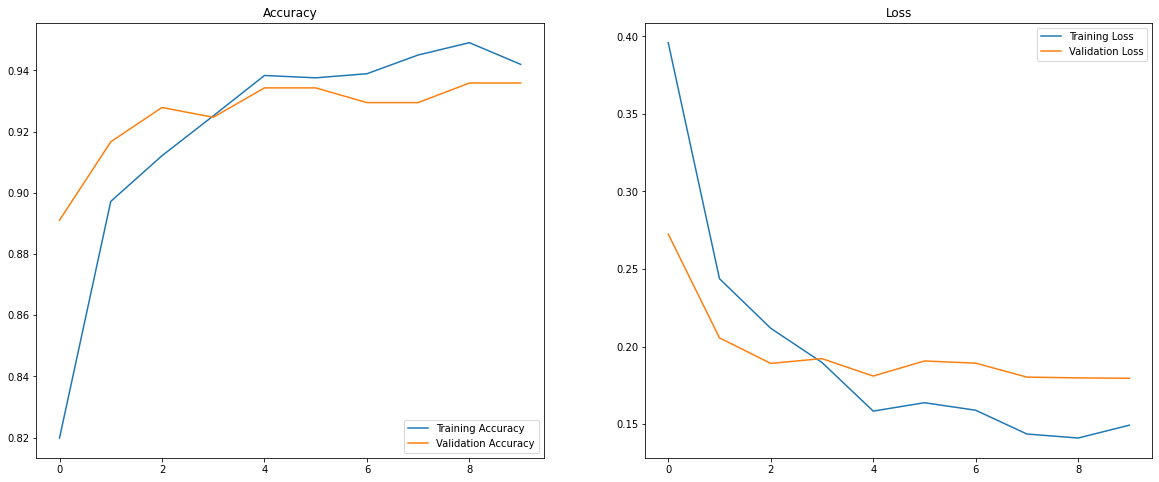

In [ ]:
plot_training(stacked_history_from_disk)

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       234
           1       0.94      0.94      0.94       390

    accuracy                           0.93       624
   macro avg       0.92      0.92      0.92       624
weighted avg       0.93      0.93      0.93       624



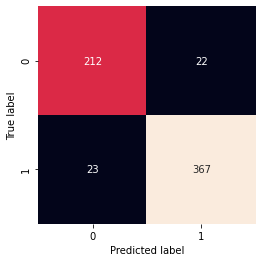

In [ ]:
test_df = prep_test_data(test_dir)
testing(stacked_model_from_disk, test_df)

# Model Evaluation on Validation Data



In [ ]:
val_data = []

for filename in os.listdir(os.path.join(val_dir, 'NORMAL')):
  val_data.append((os.path.join(val_dir, 'NORMAL', filename), 0))
for filename in os.listdir(os.path.join(val_dir, 'PNEUMONIA')):
  val_data.append((os.path.join(val_dir, 'PNEUMONIA', filename), 1))
print(f'Number of file in Val Data: {len(val_data)}')
val_df = pd.DataFrame(val_data, columns=['img_path', 'label'])

Number of file in Val Data: 16


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



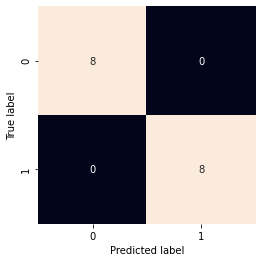

In [ ]:
testing(stacked_model_from_disk, val_df)

In [ ]:
def predict_from_df(val_df, model):
  for index, row in val_df.sample(n=5).iterrows():
    img_name = row['img_path']
    label = row['label']
    label_predicted = np.where((predict_image(model, img_name)[0][0])>0.5,'Pneumonia','Normal')
    plt.figure(figsize=(6,6))
    plt.imshow(load_img(img_name, target_size = (120,120)))
    if label == 1:
      plt.title(f"True:Pneumonia, Predicted:{label_predicted}")
    if label == 0:
      plt.title(f"True:Normal, Predicted:{label_predicted}")
    plt.axis('off')    
    plt.tight_layout()
    plt.show()

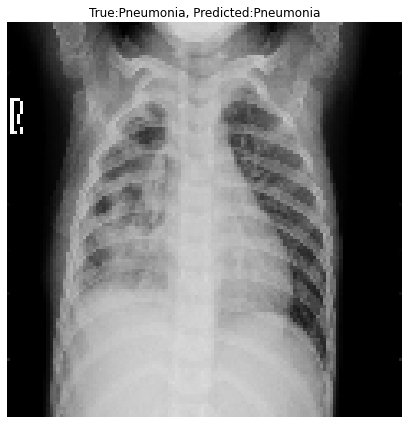

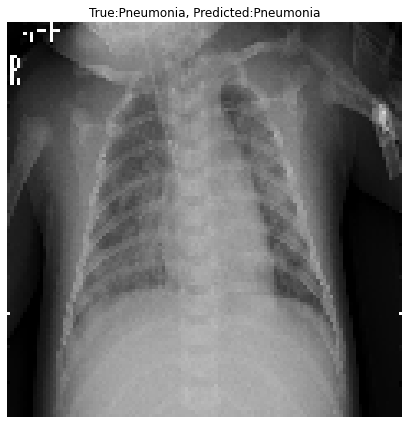

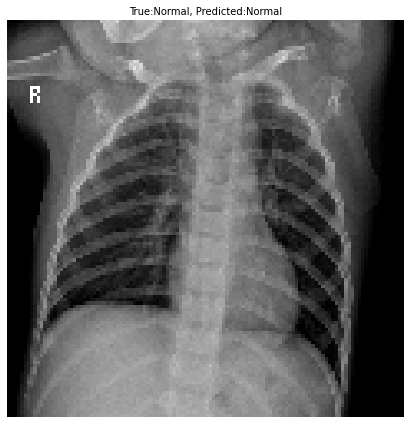

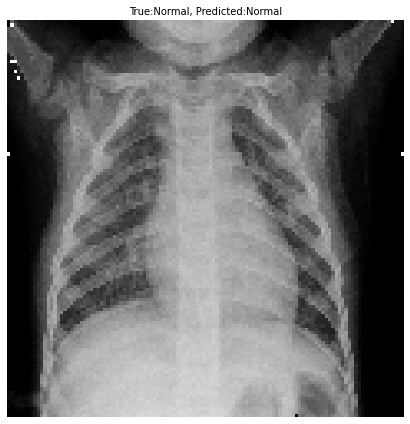

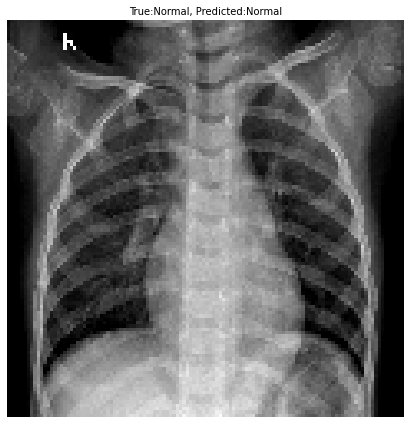

In [ ]:
predict_from_df(val_df=val_df, model=stacked_model_from_disk)

# VGG-16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
base = VGG16()
base.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
base = VGG16(include_top=False, input_shape=(224, 224, 3))

base.get_layer('block1_conv1').trainable = False
base.get_layer('block1_conv2').trainable = False
base.get_layer('block2_conv1').trainable = False
base.get_layer('block2_conv2').trainable = False
base.get_layer('block3_conv1').trainable = False
base.get_layer('block3_conv2').trainable = False
base.get_layer('block3_conv3').trainable = False
base.get_layer('block4_conv1').trainable = False
base.get_layer('block4_conv2').trainable = False
base.get_layer('block4_conv3').trainable = False

# for layer in base.layers:
#   layer.trainable = False

n_dense1, n_dense2, n_class = 1024, 512, 1
vgg16_model = Sequential()
vgg16_model.add(base)
vgg16_model.add(GlobalAveragePooling2D())
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dense(n_dense1, activation='relu'))
vgg16_model.add(Dropout(0.5))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dense(n_dense2, activation='relu'))
vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(n_class, activation='sigmoid'))
print(vgg16_model.summary())

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________

In [ ]:
opt = Adam(learning_rate=0.0001)
vgg16_model.compile(optimizer=opt, metrics=['accuracy'], loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=7, verbose=1, mode='min', baseline=None, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, min_delta=0.01, patience=6, mode='min', verbose=1)
model_save = ModelCheckpoint('/content/drive/MyDrive/Binit/pneuminia_cnn/models/vgg_16.h5',
                             monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

In [ ]:
vgg16_history = vgg16_model.fit(train_generator,
                                epochs=20, batch_size=16, verbose=1, 
                                validation_data=test_generator,
                                callbacks=[early_stop, rlr, model_save])

Epoch 1/20
328/328 [==============================] - 1992s 6s/step - loss: 0.3458 - accuracy: 0.8500 - val_loss: 0.5985 - val_accuracy: 0.7228

Epoch 00001: val_loss improved from inf to 0.59847, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/vgg_16.h5
Epoch 2/20
328/328 [==============================] - 126s 383ms/step - loss: 0.2234 - accuracy: 0.9135 - val_loss: 0.4536 - val_accuracy: 0.8429

Epoch 00002: val_loss improved from 0.59847 to 0.45362, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/vgg_16.h5
Epoch 3/20
328/328 [==============================] - 125s 382ms/step - loss: 0.1699 - accuracy: 0.9322 - val_loss: 0.2729 - val_accuracy: 0.9022

Epoch 00003: val_loss improved from 0.45362 to 0.27289, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/vgg_16.h5
Epoch 4/20
328/328 [==============================] - 125s 381ms/step - loss: 0.1566 - accuracy: 0.9403 - val_loss: 0.9689 - val_accuracy: 0.6426

Epoch 00004: val_loss 

In [ ]:
with open('/content/drive/MyDrive/Binit/pneuminia_cnn/models/vgg_16_history', 'wb') as h:
  pickle.dump(vgg16_history.history, h)

In [ ]:
vgg16_model_from_disk = load_model('/content/drive/MyDrive/Binit/pneuminia_cnn/models/vgg_16.h5')
with open('/content/drive/MyDrive/Binit/pneuminia_cnn/models/vgg_16_history', 'rb') as h:
  vgg_history_from_disk = pickle.load(h)

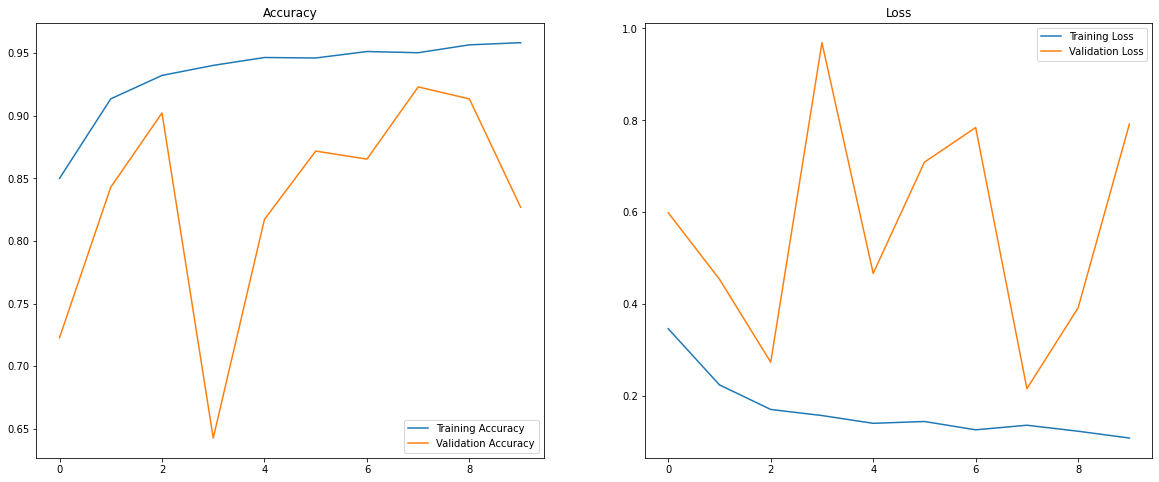

In [ ]:
plot_training(vgg_history_from_disk)

              precision    recall  f1-score   support

           0       0.94      0.83      0.88       234
           1       0.90      0.97      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



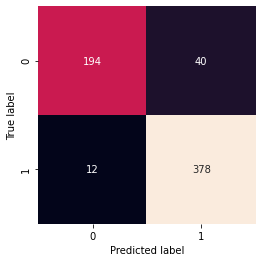

In [ ]:
test_df = prep_test_data(test_dir)
testing(vgg16_model_from_disk, test_df)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



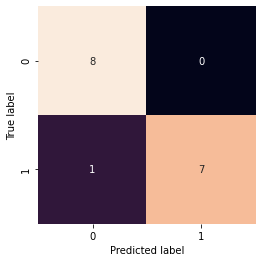

In [ ]:
testing(vgg16_model_from_disk, val_df)

## InceptionNet

In [ ]:
base = InceptionV3(include_top=False, weights='imagenet')


n_dense1, n_dense2, n_class = 1024, 512, 1
inception_model = Sequential()
inception_model.add(base)
inception_model.add(GlobalAveragePooling2D())
inception_model.add(BatchNormalization())
inception_model.add(Dense(n_dense1, activation='relu'))
inception_model.add(Dropout(0.5))
inception_model.add(BatchNormalization())
inception_model.add(Dense(n_dense2, activation='relu'))
inception_model.add(Dropout(0.5))
inception_model.add(Dense(n_class, activation='sigmoid'))
inception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization_188 (Bat (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization_189 (Bat (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               5

In [ ]:
opt = Adam(learning_rate=0.0001)
inception_model.compile(optimizer=opt, metrics=['accuracy'], loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=7, verbose=1, mode='min', baseline=None, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, min_delta=0.01, patience=6, mode='min', verbose=1)
model_save = ModelCheckpoint('/content/drive/MyDrive/Binit/pneuminia_cnn/models/inception.h5',
                             monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

In [ ]:
# inception_history = inception_model.fit(train_generator, epochs=20, batch_size=16, verbose=1,
#                                         validation_data=test_generator,
#                                         callbacks=[early_stop, rlr, model_save])

Epoch 1/20
328/328 [==============================] - 1614s 5s/step - loss: 0.2952 - accuracy: 0.8784 - val_loss: 0.5109 - val_accuracy: 0.8157

Epoch 00001: val_loss improved from inf to 0.51093, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/inception.h5
Epoch 2/20
328/328 [==============================] - 130s 395ms/step - loss: 0.2083 - accuracy: 0.9233 - val_loss: 0.4779 - val_accuracy: 0.8349

Epoch 00002: val_loss improved from 0.51093 to 0.47785, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/inception.h5
Epoch 3/20
328/328 [==============================] - 130s 395ms/step - loss: 0.1733 - accuracy: 0.9340 - val_loss: 0.3887 - val_accuracy: 0.8830

Epoch 00003: val_loss improved from 0.47785 to 0.38871, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/inception.h5
Epoch 4/20
328/328 [==============================] - 128s 391ms/step - loss: 0.1401 - accuracy: 0.9496 - val_loss: 0.3331 - val_accuracy: 0.8878

Epoch 00004: 

In [ ]:
# with open('/content/drive/MyDrive/Binit/pneuminia_cnn/models/inception_history', 'wb') as h:
#   pickle.dump(inception_history.history, h)

In [ ]:
inception_model_from_disk = load_model('/content/drive/MyDrive/Binit/pneuminia_cnn/models/inception.h5')
with open('/content/drive/MyDrive/Binit/pneuminia_cnn/models/inception_history', 'rb') as h:
  inception_history_from_disk = pickle.load(h)

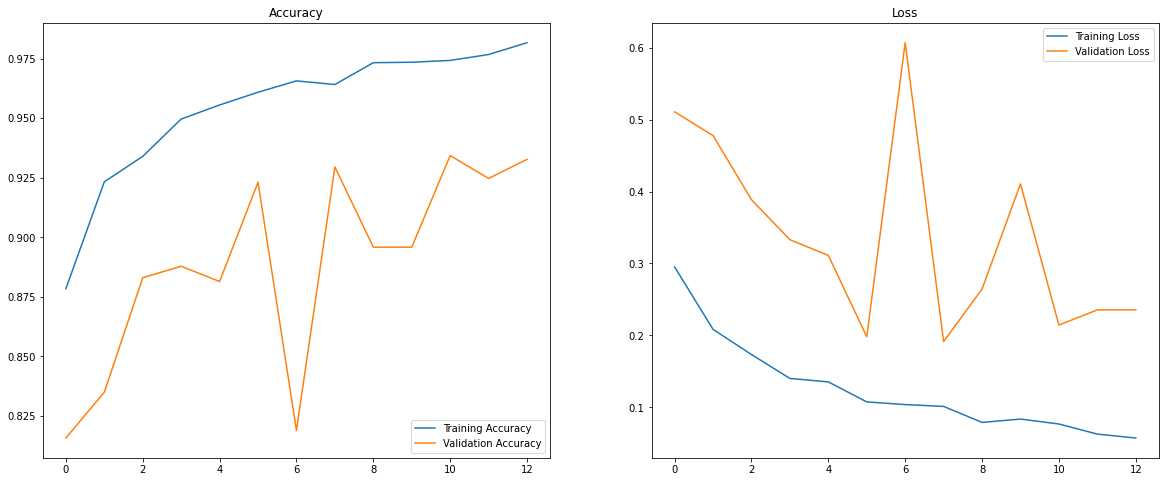

In [ ]:
plot_training(inception_history_from_disk)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       234
           1       0.94      0.96      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624



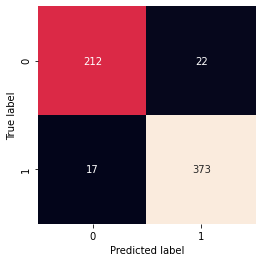

In [ ]:
testing(inception_model_from_disk, test_df)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



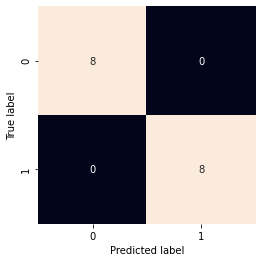

In [ ]:
testing(inception_model_from_disk, val_df)

### ResNet50

In [ ]:
base = ResNet50(include_top=False)

base.get_layer('conv1_conv').trainable = False
base.get_layer('conv2_block1_1_conv').trainable = False
base.get_layer('conv2_block1_2_conv').trainable = False
base.get_layer('conv2_block1_0_conv').trainable = False
base.get_layer('conv2_block1_3_conv').trainable = False
base.get_layer('conv2_block2_1_conv').trainable = False
# base.get_layer('conv2_block2_2_conv').trainable = False
# base.get_layer('conv2_block2_3_conv').trainable = False

n_dense1, n_dense2, n_class = 2048, 1024, 1
# x = Sequential()(base)
x = GlobalAveragePooling2D()(base.layers[-1].output)
x = BatchNormalization()(x)
x = Dense(n_dense1, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(n_dense2, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='sigmoid')(x)
resnet_model = tf.keras.models.Model(inputs=base.input, outputs=x)
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
opt = Adam(learning_rate=0.0001)
resnet_model.compile(optimizer=opt, metrics=['accuracy'], loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=12, verbose=1, mode='min', baseline=None, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, min_delta=0.01, patience=12, mode='min', verbose=1)
model_save = ModelCheckpoint('/content/drive/MyDrive/Binit/pneuminia_cnn/models/resnet50.h5',
                             monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

In [ ]:
resnet_history = resnet_model.fit(train_generator, epochs=20, batch_size=16, verbose=1,
                                  validation_data=test_generator,
                                  callbacks=[early_stop, rlr, model_save])

Epoch 1/20
328/328 [==============================] - 147s 429ms/step - loss: 0.2116 - accuracy: 0.9187 - val_loss: 0.7414 - val_accuracy: 0.6202

Epoch 00001: val_loss improved from inf to 0.74136, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/resnet50.h5
Epoch 2/20
328/328 [==============================] - 140s 425ms/step - loss: 0.1508 - accuracy: 0.9452 - val_loss: 2.1098 - val_accuracy: 0.6250

Epoch 00002: val_loss did not improve from 0.74136
Epoch 3/20
328/328 [==============================] - 138s 421ms/step - loss: 0.1491 - accuracy: 0.9487 - val_loss: 1.9685 - val_accuracy: 0.6298

Epoch 00003: val_loss did not improve from 0.74136
Epoch 4/20
328/328 [==============================] - 138s 420ms/step - loss: 0.1233 - accuracy: 0.9557 - val_loss: 0.2088 - val_accuracy: 0.9327

Epoch 00004: val_loss improved from 0.74136 to 0.20882, saving model to /content/drive/MyDrive/Binit/pneuminia_cnn/models/resnet50.h5
Epoch 5/20
328/328 [==========================

In [ ]:
with open('/content/drive/MyDrive/Binit/pneuminia_cnn/models/resnet_history', 'wb') as h:
  pickle.dump(resnet_history.history, h)

In [ ]:
resnet_model_from_disk = load_model('/content/drive/MyDrive/Binit/pneuminia_cnn/models/resnet50.h5')
with open('/content/drive/MyDrive/Binit/pneuminia_cnn/models/resnet_history', 'rb') as h:
  resnet_history_from_disk = pickle.load(h)

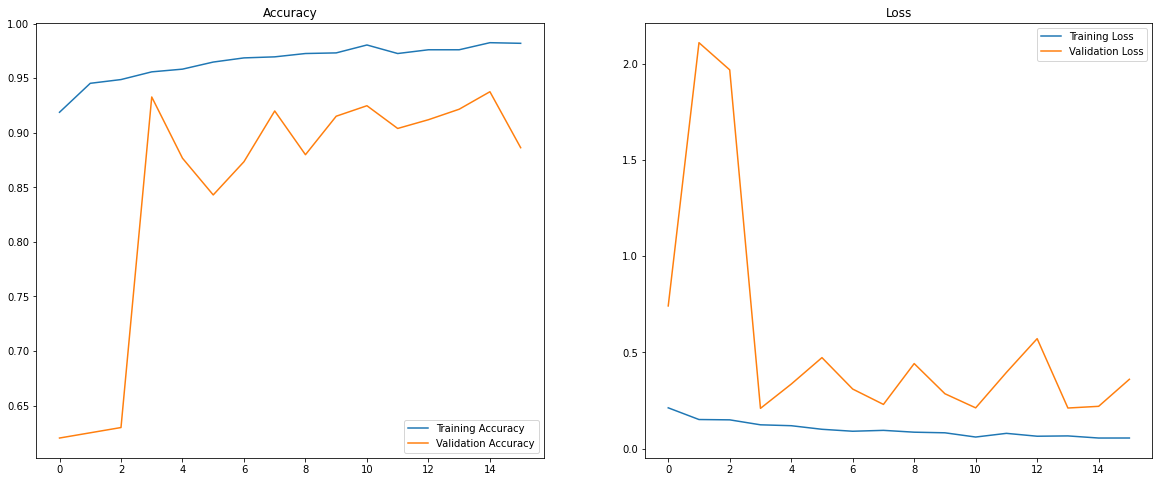

In [ ]:
plot_training(resnet_history_from_disk)

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       234
           1       0.92      0.98      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.92      0.93       624
weighted avg       0.94      0.94      0.93       624



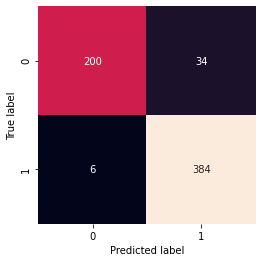

In [ ]:
testing(resnet_model_from_disk, test_df)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



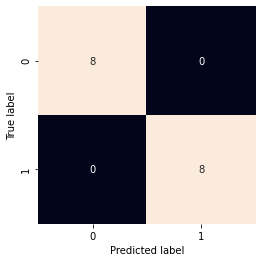

In [ ]:
testing(resnet_model_from_disk, val_df)